Hi everyone! 

Here is another take on trying to get the most out of the data when the features are assumed to be independent. The idea is to fit 200 classifiers, each using only one of the features, and then combining the predictions using Bayes' rule as in Naive Bayes methods. I've previously experimented by using kernel density estimates to obtain the individual classifiers as in Chris Deotte's kernel [here](http://www.kaggle.com/cdeotte/modified-naive-bayes-santander-0-899), but achieved better results when the individual classifiers where gradient boosted trees. Enjoy!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb

import os
print(os.listdir("../input"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
train_df = pd.read_csv("../input/train.csv")

In [3]:
# LightGBM parameters found manually. 
# I picked one feature (var_12) and tuned the parameters only on that feature. 
# I tried to keep n_iterations fairly low (~600) while still achieving good results.
params = {
    'boosting':'gbdt', 
    'bagging_freq':5,
    'bagging_fraction':0.5, # important for creating fairly smooth prediction functions.
                # without bagging, tree splits always happens at the same 1023 places and
                # the result is a very "rugged" function
    'num_leaves':2,
    'reg_lambda':100.0,
    'learning_rate':0.01, 
    'max_bin':1023, # seems to allow fitting the tails better when using more bins
    'seed':3366
}

One could of course try to tune the LGBM parameters for each feature individually, but that's just too tedious. So I prayed that the same parameters work for every feature as long as I allow the number of number of trees to vary for each feature. The following function estimates the optimal number of rounds for each feature.

In [4]:
def optimal_rounds(X, verbose=False):
    """
    Runs LGBM with 3-fold CV on each feature separately with early stopping and
    determines the optimal number of trees for each feature.
    """
    rounds = []
    for i in range(200):
        if verbose:
            print("Feature ", i)
        cv_res = lgb.cv(params, 
           lgb.Dataset(X[['var_'+str(i)]], X['target']),
           nfold=3, # increasing this doesn't seem to matter much, so keep it low for speed
           num_boost_round=100000,
           metrics='binary_logloss',
           verbose_eval=100 if verbose else None,
           early_stopping_rounds=100
          )
        rounds.append(len(cv_res['binary_logloss-mean']))
    return rounds

It is important that the metric used for the early stopping is the binary logloss (or something similar) and not the AUC score! For many features, the probability function to predict seem to be monotonic. That is, the larger the value of that feature the more likely that the class value is 1 (or 0). In these cases, **any** monotonic predictor will have the same (and best possible) AUC score, since all induce the same ranking of the observations. But a random monotonic function is not good for anything, since it is crucial for Naive Bayes is to estimate the individual conditional probabilities as accurately as possible.

In [5]:
opt_rounds = optimal_rounds(train_df, verbose=True)

Feature  0
[100]	cv_agg's binary_logloss: 0.324643 + 0.000112501
[200]	cv_agg's binary_logloss: 0.324307 + 0.000144592
[300]	cv_agg's binary_logloss: 0.324229 + 0.000148846
[400]	cv_agg's binary_logloss: 0.324217 + 0.000153991
Feature  1
[100]	cv_agg's binary_logloss: 0.324862 + 2.69714e-05
[200]	cv_agg's binary_logloss: 0.324486 + 2.77672e-05
[300]	cv_agg's binary_logloss: 0.324365 + 2.0729e-05
[400]	cv_agg's binary_logloss: 0.324333 + 1.02923e-05
[500]	cv_agg's binary_logloss: 0.324326 + 4.91504e-06
[600]	cv_agg's binary_logloss: 0.32433 + 4.53892e-06
Feature  2
[100]	cv_agg's binary_logloss: 0.324606 + 0.000195444
[200]	cv_agg's binary_logloss: 0.324209 + 0.000286782
[300]	cv_agg's binary_logloss: 0.324101 + 0.000346028
[400]	cv_agg's binary_logloss: 0.324083 + 0.00037177
[500]	cv_agg's binary_logloss: 0.324085 + 0.00038213
[600]	cv_agg's binary_logloss: 0.324082 + 0.000382774
Feature  3
[100]	cv_agg's binary_logloss: 0.326073 + 3.99854e-05
[200]	cv_agg's binary_logloss: 0.326047 + 

In [6]:
print("Optimal number of rounds: ", opt_rounds)
print("Optimal number of rounds for var_108: ", opt_rounds[108])
print("Optimal number of rounds for var_30: ", opt_rounds[30])

Optimal number of rounds:  [370, 535, 565, 302, 185, 345, 580, 5, 310, 1160, 200, 255, 665, 490, 145, 225, 230, 10, 426, 430, 600, 835, 595, 330, 440, 225, 430, 11, 444, 71, 1, 405, 435, 515, 485, 400, 542, 250, 10, 142, 490, 55, 88, 316, 425, 230, 90, 140, 367, 400, 208, 610, 350, 524, 555, 410, 430, 274, 234, 354, 175, 198, 265, 335, 240, 120, 375, 380, 290, 245, 420, 470, 175, 65, 420, 465, 450, 240, 495, 115, 1064, 420, 337, 358, 185, 350, 344, 540, 280, 405, 395, 575, 555, 290, 875, 305, 40, 226, 115, 460, 135, 333, 185, 5, 700, 255, 345, 475, 2465, 495, 482, 375, 650, 225, 375, 455, 285, 65, 725, 405, 160, 455, 400, 445, 235, 300, 55, 830, 530, 156, 555, 405, 322, 455, 460, 445, 10, 365, 300, 725, 200, 432, 260, 205, 365, 395, 490, 525, 637, 585, 745, 585, 155, 100, 470, 320, 315, 290, 65, 250, 165, 110, 365, 375, 440, 590, 534, 415, 280, 475, 440, 250, 395, 625, 515, 315, 132, 505, 320, 345, 360, 275, 65, 60, 440, 10, 515, 278, 420, 160, 605, 555, 735, 205, 355, 300, 720, 440, 5

As we can see, the optimal number of rounds varies greatly. 

There are features that require quite a long training. For example, it seems that the distibution of var_108 has a sharp spike somewhere at the middle and that takes a long time to take into account. (See the end of this notebook for a figure.) The kernel density estimate in Chris's [kernel](http://www.kaggle.com/cdeotte/modified-naive-bayes-santander-0-899) does seem to see this spike very well, so this might illustrate why this version of Naive Bayes performs slightly better.

Interestingly, there are also features where the optimal number of trees is less then 10, indicating that those features might be very weak predictors (or perhaps that the chosen LGBM parameters just don't work well for those features).

Next, we implement our LGB Naive Bayes classifier.

In [7]:
from sklearn.utils.fixes import logsumexp

num_ones = np.sum(train_df['target'] == 1)
num_zeros = np.sum(train_df['target'] == 0)

class LGBNaiveBayes:
    def fit(self,X_train, y_train, opt_rounds):
        self.clfs = []
        for i in range(200):
            if i%20 == 0:
                print("Fitting var_"+ str(i)+"...")
            params['n_estimators'] = opt_rounds[i]

            lgb_clf = lgb.LGBMClassifier(**params)
            lgb_clf.fit(X_train[['var_'+str(i)]], y_train)

            self.clfs.append(lgb_clf)
            
    def predict_proba(self,X):
        log_sum = np.zeros((X.shape[0],2))
        for i in range(200):
            # Adding up the log-probabilities to compute the joint probabilities. 
            # This assumes independence of the features just like other Naive Bayes methods.
            log_sum += np.log(self.clfs[i].predict_proba(X[['var_'+str(i)]]))
            
            # Correcting with the apriori log-probabilities of the two classes. This does not
            # have an effect on the AUC score since it shifts all log-probabilities with the 
            # same amount and hence does not change the ranking of the observations.
            # Without these correction though, the predicted probabilities of class 1 would be
            # extremely small though which is both incorrect and inconvenient when comparing to
            # predictions obtained from other classifiers.
            log_sum += np.array([np.log(num_ones) - np.log(200000), np.log(num_zeros) - np.log(200000)])
        # One last correction term for the final log-probabilities. Again, it is not important for
        # the AUC score.
        log_sum -= np.array([np.log(num_ones) - np.log(200000), np.log(num_zeros) - np.log(200000)])
        
        # Applying numerically stable softmax using logs, inspired by the scikit-learn
        # implementation of Naive Bayes.
        log_prob_x = logsumexp(log_sum, axis=1)
        return np.exp(log_sum - np.atleast_2d(log_prob_x).T)



In [8]:
clf = LGBNaiveBayes()

Performing 5-fold CV.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

features = train_df.columns[2:].values

def cross_validate(nfolds):
    sss = StratifiedShuffleSplit(nfolds)
    aucs = []
    for train, test in sss.split(train_df[features], train_df['target']):
        clf.fit(train_df.loc[train][features], train_df.loc[train]['target'], opt_rounds)
        y_true = train_df.loc[test]['target']
        y_pred = clf.predict_proba(train_df.loc[test][features])[:,1]
        test_auc = roc_auc_score(y_true, y_pred)
        aucs.append(test_auc)
        print("Test AUC:", test_auc)
    print("Mean test AUC: ", np.mean(aucs))
    
cross_validate(5)

Fitting var_0...
Fitting var_20...
Fitting var_40...
Fitting var_60...
Fitting var_80...
Fitting var_100...
Fitting var_120...
Fitting var_140...
Fitting var_160...
Fitting var_180...
Test AUC: 0.897350711699977
Fitting var_0...
Fitting var_20...
Fitting var_40...
Fitting var_60...
Fitting var_80...
Fitting var_100...
Fitting var_120...
Fitting var_140...
Fitting var_160...
Fitting var_180...
Test AUC: 0.9018301488665622
Fitting var_0...
Fitting var_20...
Fitting var_40...
Fitting var_60...
Fitting var_80...
Fitting var_100...
Fitting var_120...
Fitting var_140...
Fitting var_160...
Fitting var_180...
Test AUC: 0.9028010862861899
Fitting var_0...
Fitting var_20...
Fitting var_40...
Fitting var_60...
Fitting var_80...
Fitting var_100...
Fitting var_120...
Fitting var_140...
Fitting var_160...
Fitting var_180...
Test AUC: 0.9031366237185392
Fitting var_0...
Fitting var_20...
Fitting var_40...
Fitting var_60...
Fitting var_80...
Fitting var_100...
Fitting var_120...
Fitting var_140...
Fit

Creating submission:

In [10]:
test_df = pd.read_csv('../input/test.csv')
clf.fit(train_df[features], train_df['target'], opt_rounds)
pred = clf.predict_proba(test_df.iloc[:][features])
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = pred[:,1]
sub_df.to_csv("submission.csv", index=False)

Fitting var_0...
Fitting var_20...
Fitting var_40...
Fitting var_60...
Fitting var_80...
Fitting var_100...
Fitting var_120...
Fitting var_140...
Fitting var_160...
Fitting var_180...


Finally, here is the prediction plot for var_108. The spike in the middle is nicely recognized.

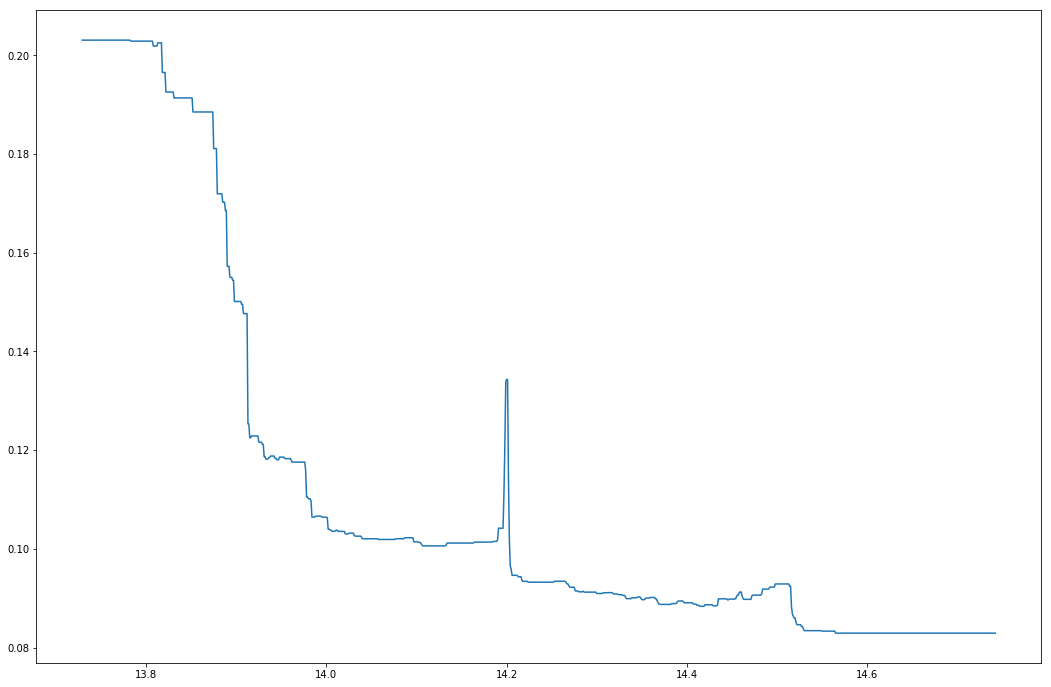

In [11]:
import matplotlib.pyplot as plt
x1 = min(train_df['var_108'])
x2 = max(train_df['var_108'])
data = np.arange(x1, x2, 0.001)
fig = plt.figure(figsize=(18,12))
plt.plot(data, clf.clfs[108].predict_proba(data.reshape(-1,1))[:,1])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


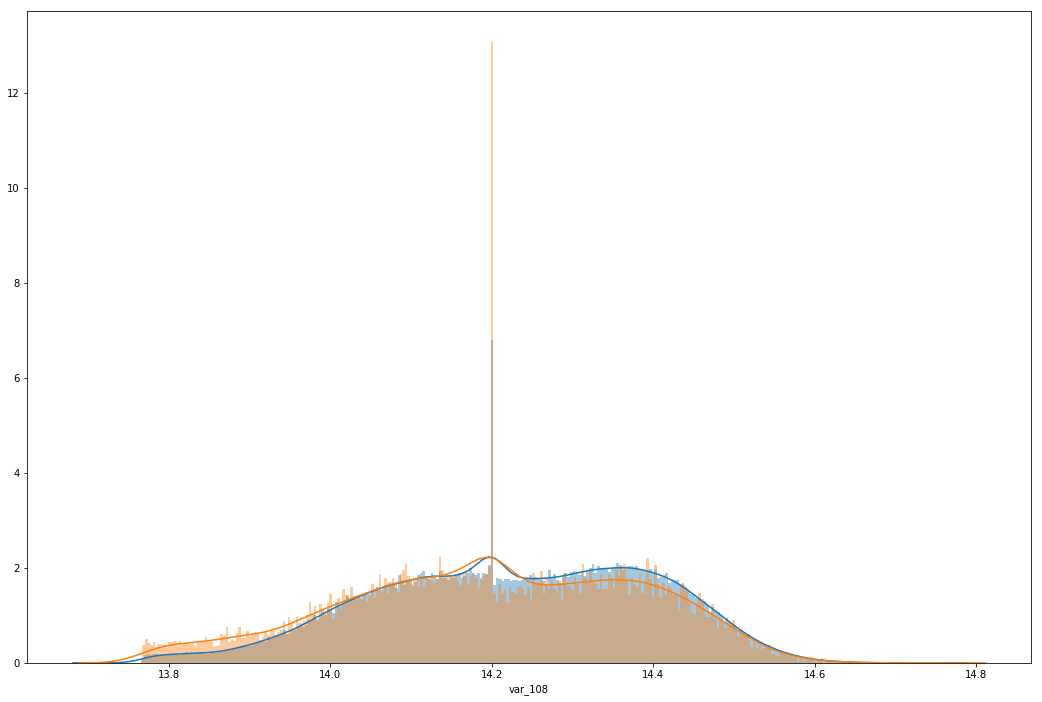

In [12]:
import seaborn as sns
plt.figure(figsize=(18,12))
sns.distplot(train_df.loc[train_df['target']==0]['var_108'], bins=300)
sns.distplot(train_df.loc[train_df['target']==1]['var_108'], bins=300)